In [5]:
#Import packages
import os
import glob
import json
#from tqdm import tqdm

import nilearn
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix, run_glm
from nilearn.glm.second_level import make_second_level_design_matrix, SecondLevelModel
from nilearn.glm import fdr_threshold,threshold_stats_img
from nilearn.glm.contrasts import compute_contrast


from bids.layout import BIDSLayout, parse_file_entities

# import cortex
# from cortex import fmriprep

from nipype.interfaces.workbench.base import WBCommand
from nipype.algorithms import modelgen
from nipype.interfaces.base import Bunch

import scipy.stats as stats

import hcp_utils as hcp

import first_level_sparse_scanning as flss 
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
%matplotlib inline

In [50]:
img_root = '../../derivatives/first_level_emosent_sadneutral_112713'
sub = 'voice856'
ses = 1
task = 'emosent'
run = 2
con = 'speechvsil'
first_level_img = f'{img_root}/sub-{sub}_ses-1_task-emosent_rec-unco_run-{run}_space-fsLR_den-91k_contrast-{con}_z_score.dscalar.nii'


In [ ]:
signal = np.squeeze(nimg.load_img(first_level_img).get_fdata(dtype='f4'))

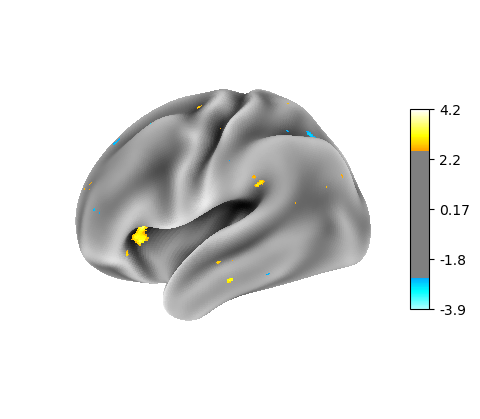

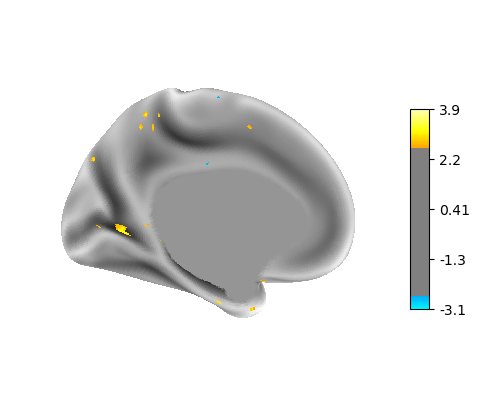

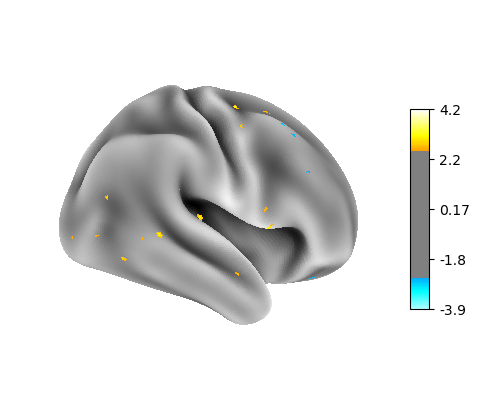

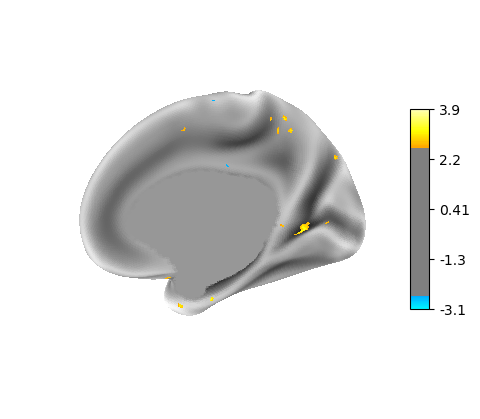

In [29]:
vmax = signal.max()
nplot.plot_surf_stat_map(
    hcp.mesh.inflated, hcp.cortex_data(signal), hemi='left', #
    threshold=2.575,#thresholds[col],output_file = f'{output_folder}/{col}_contrast-{contrast}_hemi-LH_view-lateral.png',
    symmetric_cbar = False, 
    colorbar=True,#title = f'{col}, LH', #output_file=f'parcel_wall_of_speech/{c}.png'
    title_font_size=30, vmax = vmax,
    bg_map=hcp.mesh.sulc)

nplot.plot_surf_stat_map(
    hcp.mesh.inflated_left, hcp.left_cortex_data(signal), view= 'lateral',
    hemi='right', threshold=2.575,#thresholds[col],output_file = f'{output_folder}/{col}_contrast-{contrast}_hemi-LH_view-medial.png',
    symmetric_cbar = False,
    colorbar=True, vmax = vmax,  
    bg_map=hcp.mesh.sulc_left)

nplot.plot_surf_stat_map(
    hcp.mesh.inflated, hcp.cortex_data(signal), hemi='right', 
    threshold=2.575,#thresholds[col],output_file = f'{output_folder}/{col}_contrast-{contrast}_hemi-RH_view-lateral.png',
    symmetric_cbar = False, #output_file=f'parcel_wall_of_speech/{c}.png'
    colorbar=True, vmax = vmax, #title = f'{col}, RH',
    bg_map=hcp.mesh.sulc)

nplot.plot_surf_stat_map(
    hcp.mesh.inflated_right, hcp.left_cortex_data(signal), view= 'lateral',
    hemi='left', threshold=2.575,#thresholds[col]output_file = f'{output_folder}/{col}_contrast-{contrast}_hemi-RH_view-medial.png',
    symmetric_cbar = False, 
    colorbar=True, vmax = vmax,
    bg_map=hcp.mesh.sulc_right)

#subcortical = utils.volume_from_cifti(effect_size_signals_combined[col], axes[1])#.get_fdata(dtype='f4')
#     nplot.plot_stat_map(subcortical, threshold=thresholds[col], vmax=vmax)
#, title=f'{task}: group task beta for syllables contrast')

nplot.show()

In [210]:
pheno_root = '/nese/mit/group/sig/om_projects/voice/rawData'
psychopy = f'{pheno_root}/voice856/session001_visit002/behavioral/20151030121456_voice856_S001_T005_R002_emosent.log'
audio = f'{pheno_root}/audio/voice856_S001_T005_R002_emosent.wav'

In [64]:
log_files = glob.glob(f'{pheno_root}/voice856/session001_visit002/behavioral/*emosent*.log')
log_files = sorted([lo.split('behavioral/')[1] for lo in log_files])
#log_files = pd.Series(log_files, name='psychopy_log')
log_files
# {lo.split('R00')[1].split('_emosent')[0]: 
#  lo.split('behavioral/')[1].split('_voice')[0] 
#  for lo in log_files}

['20151030121037_voice856_S001_T005_R001_emosent.log',
 '20151030121456_voice856_S001_T005_R002_emosent.log']

In [56]:
scan_info = pd.read_table('../../sub-voice856/ses-1/sub-voice856_ses-1_scans.tsv')
scan_info = scan_info[scan_info.filename.str.contains('emosent' )]#[['filename', 'acq_time']].reset_index(drop=True)
#scan_info.rename(columns={'filename':'raw_nifti_filename'}, inplace=True)

In [236]:
control = np.arange(985,1000).astype('str')
control

array(['985', '986', '987', '988', '989', '990', '991', '992', '993',
       '994', '995', '996', '997', '998', '999'], dtype='<U21')

In [238]:
[c for c in control]

['985',
 '986',
 '987',
 '988',
 '989',
 '990',
 '991',
 '992',
 '993',
 '994',
 '995',
 '996',
 '997',
 '998',
 '999']

In [239]:
subjects[-1]

'999'

In [242]:
subjects = [pre.split('voice')[1].split('/')[0] for pre in glob.glob('../../derivatives/fmriprep/sub-voice*/')]
[subjects.remove(c) for c in control if c in subjects]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [224]:
# scan_files = [s for s in scan_files if '000' not in s]
# scan_files = scan_files[:-15]

psychopy_files = glob.glob(f'{pheno_root}/voice*/session001_visit00*/behavioral/*emosent*log')
psychopy_files
#[p for p in psychopy_files if 'TrailTestAB' not in p]

# a1 = [p for p in psychopy_files if 'TrailTestAB' not in p]
# [p for p in a1 if '.mat' not in p]

['/nese/mit/group/sig/om_projects/voice/rawData/voice844/session001_visit002/behavioral/20170221194023_voice844_S001_T005_R001_emosent.log',
 '/nese/mit/group/sig/om_projects/voice/rawData/voice844/session001_visit002/behavioral/20170221194626_voice844_S001_T005_R002_emosent.log',
 '/nese/mit/group/sig/om_projects/voice/rawData/voice846/session001_visit002/behavioral/20161215165304_voice846_S001_T005_R001_emosent.log',
 '/nese/mit/group/sig/om_projects/voice/rawData/voice846/session001_visit002/behavioral/20161215165712_voice846_S001_T005_R002_emosent.log',
 '/nese/mit/group/sig/om_projects/voice/rawData/voice849/session001_visit002/behavioral/20160405164936_voice849_S001_T005_R001_emosent.log',
 '/nese/mit/group/sig/om_projects/voice/rawData/voice849/session001_visit002/behavioral/20160405165503_voice849_S001_T005_R002_emosent.log',
 '/nese/mit/group/sig/om_projects/voice/rawData/voice850/session001_visit002/behavioral/20160225173614_voice850_S001_T005_R001_emosent.log',
 '/nese/mit/g

In [212]:
f'{pheno_root}/voice*/behavioral/session001_visit001/*'

'/nese/mit/group/sig/om_projects/voice/rawData/voice*/behavioral/session001_visit001/*'

In [165]:
from datetime import datetime, timedelta

scan_info = pd.read_table('../../sub-voice856/ses-1/sub-voice856_ses-1_scans.tsv')
scan_info = scan_info[scan_info.filename.str.contains('emosent' )]#[['filename', 'acq_time']].reset_index(drop=True)

for i,scan in scan_info.iterrows():
    #scan_date_str = times
    s_time_format = '%Y-%m-%dT%H:%M:%S.%f'

    s_time_obj = datetime.strptime(scan.acq_time, s_time_format)
    s_time_obj = s_time_obj.replace(second=0, microsecond=0)
    
    for log in log_files:
        log_time = log.split('_voice')[0]
        log_time_format = '%Y%m%d%H%M%S'

        log_time_obj = datetime.strptime(log_time, log_time_format)
        log_time_obj = log_time_obj.replace(second=0)
        #print(s_time_obj, log_time_obj, timedelta(minutes = -2) < s_time_obj - log_time_obj < timedelta(minutes = 2))
        if timedelta(minutes = -2) < s_time_obj - log_time_obj < timedelta(minutes = 2):
            print(scan.filename)

func/sub-voice856_ses-1_task-emosent_run-2_bold.nii.gz
func/sub-voice856_ses-1_task-emosent_run-3_bold.nii.gz


In [198]:
scan_files = glob.glob('../../sub-voice*/ses-1/sub-voice*_ses-1_scans.tsv')
scan_files = [s for s in scan_files if '000' not in s]
scan_files = scan_files[:-15]

In [46]:
pd.concat([scan_info, log_files], axis=1)

,raw_nifti_filename,acq_time,psychopy_log
0,func/sub-voice856_ses-1_task-emosent_run-1_bol...,2015-10-30T11:16:13.982500,20151030121037_voice856_S001_T005_R001_emosent...
1,func/sub-voice856_ses-1_task-emosent_run-2_bol...,2015-10-30T12:10:58.875000,20151030121456_voice856_S001_T005_R002_emosent...
2,func/sub-voice856_ses-1_task-emosent_run-3_bol...,2015-10-30T12:15:09.762500,NaN


In [47]:
events = glob.glob(f'/nese/mit/group/sig/om_projects/voice/bids/data/sub-voice856/ses-1/func/*emosent*events.tsv')
events

['/nese/mit/group/sig/om_projects/voice/bids/data/sub-voice856/ses-1/func/sub-voice856_ses-1_task-emosent_run-01_events.tsv',
 '/nese/mit/group/sig/om_projects/voice/bids/data/sub-voice856/ses-1/func/sub-voice856_ses-1_task-emosent_run-02_events.tsv']

In [10]:
tasks_included = ['emosent']
parsed_valid_runs = flss.parse_valid_runs(tasks_included, qc_filter= True)

In [11]:
len(parsed_valid_runs)

83

In [12]:
[p for p in parsed_valid_runs if p['subject'] == 'voice856']

[{'subject': 'voice856',
  'session': '1',
  'task': 'emosent',
  'run': 01,
  'suffix': 'events',
  'extension': '.tsv'},
 {'subject': 'voice856',
  'session': '1',
  'task': 'emosent',
  'run': 02,
  'suffix': 'events',
  'extension': '.tsv'}]

In [53]:
flss.get_confounds(sub,task,ses,3)

,framewise_displacement,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,cosine00,cosine01,a_comp_cor_00,a_comp_cor_01,a_comp_cor_02,a_comp_cor_03,a_comp_cor_04
0,0.000000,-0.000321,-0.030798,0.006451,-0.005622,-0.001397,-0.001673,0.204015,0.203687,-0.119930,0.132518,0.088799,-0.105216,0.100078
1,0.509599,0.017325,-0.239942,-0.197676,-0.005319,-0.000234,-0.001779,0.203141,0.200202,0.215433,0.181158,0.046286,-0.083501,-0.149239
2,0.261253,0.059776,-0.286872,-0.211542,-0.005980,0.000356,0.000129,0.201398,0.193291,0.221262,-0.042171,0.006477,-0.005940,-0.100976
3,0.454595,0.033830,-0.126534,-0.085847,-0.006792,0.000237,0.002050,0.198792,0.183073,0.015596,0.140017,0.211517,-0.171699,0.005869
4,0.421186,0.073145,-0.201324,-0.175137,-0.004319,0.001669,0.002500,0.195335,0.169723,0.135712,-0.004088,0.237344,-0.087352,-0.113121
5,0.209351,0.004259,-0.212606,-0.138829,-0.004520,0.001533,0.000980,0.191041,0.153469,0.115182,0.081950,-0.214605,-0.018481,-0.266773
6,0.760265,-0.012295,0.004041,0.055436,-0.003674,-0.002343,-0.000954,0.185929,0.134588,-0.236827,-0.145068,-0.192926,-0.088296,0.066407
7,0.241037,-0.041784,-0.064329,-0.009398,-0.004376,-0.002195,-0.001670,0.180021,0.113405,-0.129295,0.081396,-0.052473,-0.210883,0.249488
8,0.175482,-0.024072,-0.023374,0.004796,-0.003633,-0.000966,-0.001751,0.173343,0.090282,-0.168159,-0.073571,0.017174,0.069935,0.094580
9,0.359071,-0.023187,-0.172248,-0.123812,-0.002273,-0.000805,-0.001844,0.165922,0.065614,0.076813,-0.064215,0.073651,0.103022,-0.129913
